# Jupyter notebook interface for C-based ODE Solver
### Introduction to Computational Physics Course (PHYS-352)
### Author: Sasha Tchekhovskoy
### Version history:
 * version 0.7 as of 2/24/2021:
     * Improved the sectioning
 * version 0.6 as of 2/24/2021:
     * add comments for solve_ode() and func()
 * version 0.5 as of 2/24/2021:
     * simplify detection of numba function
     * clarify gcc installation instructions for Windows machines
     * remove carray import since not needed
 * version 0.4 as of 2/24/2021:
     * add a note that one needs to shut down and restart the jupyter server after installing gcc and updating the system PATH variable on Windows
 * version 0.3 as of 2/24/2021:
     * compile the ODE library from inside the jupyter notebook
     * make sure numba works on all distributions
     * include instructions on installing mingw
 * version 0.2 as of 2/24/2021:
     * Use numba for C callback of func() to speeds up the ODE integration by >~10x times
 * version 0.1 as of 2/21/2021:
     * Initial release

In [1]:
import ctypes
from ctypes import *
from numpy.ctypeslib import ndpointer
import numpy as np
import matplotlib.pyplot as plt
import numba

# 1. ODE library
## First, let's compile the ODE library
For this, make sure that `ode.c` and `ode.h` are in the same directory as the current file, `ode.ipynb`. To compile the ODE library, select the next cell and press "Shift+Enter":

In [2]:
!gcc -shared -O2 ode.c -o libode.so

If the above has completed successfully (without any output), you have compiled the library! If you are under Windows and the above command does not work because `gcc` is not found, try installing `Mingw-w64` by following the Steps 3 and 4 here: https://code.visualstudio.com/docs/cpp/config-mingw#_prerequisites . After you have installed `Mingw-w64` in Step 3 and updated the PATH variable in Step 4, we need to makes sure the jupyter notebook is aware of this. So, shut down the jupyter server and restart it. Then, the above command should work. Please let me know if it does not!

## Second, create a wrapper function for calling our C library ODE solver
Here, we use the CTYPES python library to interface with C libraries. Please see this link for more information: https://docs.python.org/3/library/ctypes.html . While you do not need to change anything in the following cell, I am very happy to explain what's going on here.

In [3]:
#load our C library, it's as simple as that!
lib = ctypes.CDLL("libode.so")
#rename C-based solve_ode() function into solve_ode_c()
solve_ode_c = lib.solve_ode
#in order to call a C function, we need to define:
# * the return data type
solve_ode_c.restype = None
# * function argument types
solve_ode_c.argtypes = [
    ndpointer(ctypes.c_double), 
    ndpointer(ctypes.c_double),
    ctypes.c_double,
    ctypes.c_int,
    ctypes.c_int,
    ctypes.c_int,
    ndpointer(ctypes.c_double),
    ctypes.CFUNCTYPE(None,c_double, POINTER(c_double), POINTER(c_double), POINTER(c_double))
]

#In order to "hide" from the end user the C "guts" of the library, 
#let's create a python "wrapper function" for our ODE solver
def solve_ode(fun, t_span, nsteps, y0, method = "RK4", args = None ):
    """
    Takes in the right-hand side function fun, the time range t_span, 
    the number of time steps nsteps, and the initial condition vector y0.
    
    Keyword arguments: 
    method -- one of "Euler", "Euler-Cromer", "RK2", "RK4" ODE solution methods
    args   -- arguments to pass to the right-hand side function fun()
    
    Returns: the pair t,y of time and solution vector.
    """
    t_span = np.asarray(t_span,dtype=np.double)
    t = np.linspace(t_span[0],t_span[1],nsteps+1,dtype=np.double)
    nvar = len(y0)
    y = np.zeros([nsteps+1,nvar],dtype=np.double,order='C')
    #assign initial conditions
    y0 = np.asarray(y0,dtype=np.double)
    y[0,:] = y0
    #check if the supplied function is numba-based CFunc
    if("ctypes" in dir(fun)):
        #numba-based, we can use it right away
        fun_c = fun.ctypes
    else:
        #otherwise, we need to wrap the python function into CFUNCTYPE
        FUNCTYPE = CFUNCTYPE(None,c_double, POINTER(c_double), POINTER(c_double), POINTER(c_double))
        #create a C-compatible function pointer
        fun_c = FUNCTYPE(fun)
    #compute preliminaries to call the C function library
    dt = (t_span[1]-t_span[0])/nsteps
    if args is not None: args = np.asarray(args,dtype=np.double)
    if method in ["RK2", "RKO2"]:
        order = 2
    elif method in ["Euler"]:
        order = 1
    elif method in ["Euler-Cromer"]:
        order = -1
    else:
        #default
        order = 4
    
    #make a call to the C library function
    solve_ode_c(t,y,dt,nsteps,nvar,order,args,fun_c)

    return t,y

# 2. Solving the System
## First, define the right-hand side function: $\frac{d\vec y}{dt} = \vec f(t,\vec y)$

In [4]:
#This has been updated to use numba, which compiles the below function on the fly
#and substantially speeds up the ODE integration
from numba import cfunc, types

c_sig = types.void(types.double,
                   types.CPointer(types.double),
                   types.CPointer(types.double),
                   types.CPointer(types.double))

@cfunc(c_sig)
def func(t,y,params,dydt):
    """
    Takes the time and solution vector y, as well as parameters in the params array, 
    and returns the right-hand side function, dydt
    """
    theta = y[0]
    dtheta_dt = y[1]
    dydt[0] = dtheta_dt
    dydt[1] = -np.sin(theta)*params[0]/params[1] - params[2]*dtheta_dt + params[3]*np.sin(params[4]*t)

## Second, call the python wrapper for the ODE solver
Find solution over the interval $t \in [0,80]$, using 1600 time steps, for the initial condition $(\theta_0,\omega_0) = (0.2,0)$ and pendulum parameters $(g,l) = (9.8,9.8)$, without friction ($q = 0$), using RK4 method

In [5]:
t,y = solve_ode(func,[0.,80.], 1600, [0.2,0.0], args=[9.8, 9.8, 0, 0, 0], method="RK4")
theta = y[:,0]
omega = y[:,1]

## Third, plot the results!

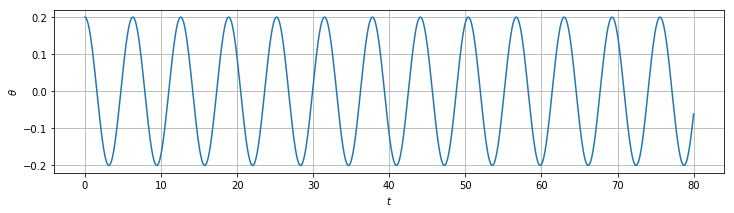

In [7]:
plt.figure(figsize=(12,3))
plt.plot(t,theta)
plt.grid()
plt.ylabel(r"$\theta$")
plt.xlabel(r"$t$")
plt.savefig("theta_vs_t.png")

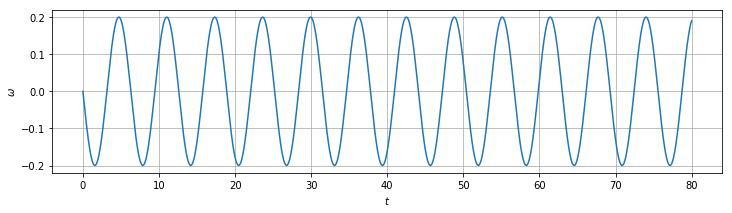

In [8]:
plt.figure(figsize=(12,3))
plt.plot(t,omega)
plt.grid()
plt.ylabel(r"$\omega$")
plt.xlabel(r"$t$")
plt.savefig("omega_vs_t.png")

### Check energy conservation: RK4 makes the smallest error in energy conservation

3.413930279066747e-07


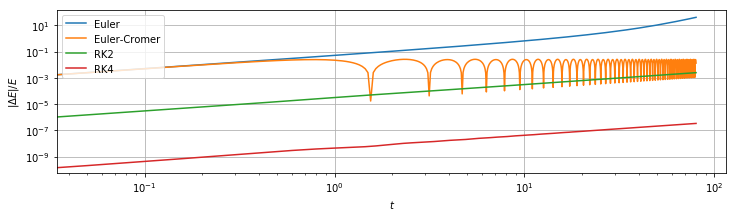

In [7]:
plt.figure(figsize=(12,3))
for method in ["Euler", "Euler-Cromer", "RK2", "RK4"]:
    t,y = solve_ode(func,[0.,80.], 1600, [0.2,0.0], args=[9.8, 9.8, 0, 0, 0], method=method)
    theta,omega = y.T
    energy = .5*(omega**2)+1.0-np.cos(theta)
    denergy = np.abs((energy - energy[0])/energy[0])
    plt.plot(t,denergy,label=r"%s" % method)
plt.yscale("log")
plt.xscale("log")
print(denergy[-1])
plt.legend()
plt.grid()
plt.ylabel(r"$|\Delta E|/E$")
plt.xlabel(r"$t$")
plt.savefig("theta_vs_t.png")

### ... although, you can see that energy error still keeps increasing even with RK4 (note this plot is on a log-log scale)

## Congrats!!! You have learned how to call C libraries from python!

# 3. Now, let's play around with the optional Assignment 5

## Case 1: friction only: $F_D=0, g/l=0, q = 1$ 

### Initial conditions: $\theta_0 = \{0.1,0.2\}, \omega_0 = 0$

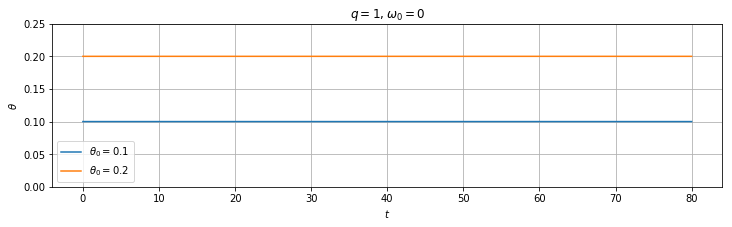

In [8]:
plt.figure(figsize=(12,3))

t,y = solve_ode(func,[0.,80.], 1600, [0.1,0.0], args=[0, 9.8, 1, 0, 0], method="RK4")
theta, omega = y.T
plt.plot(t,theta,label=r"$\theta_0 = 0.1$")

t,y = solve_ode(func,[0.,80.], 1600, [0.2,0.0], args=[0, 9.8, 1, 0, 0], method="RK4")
theta, omega = y.T
plt.plot(t,theta,label=r"$\theta_0 = 0.2$")

plt.legend()
plt.grid()

plt.title(r"$q = 1, \omega_0 = 0$")
plt.ylim(0,0.25)

plt.ylabel(r"$\theta$")
plt.xlabel(r"$t$")
plt.savefig("case_1_theta_vs_t_om0.png")

#### what's going on here? share your thoughts!

### Initial conditions: $\theta_0=0, \omega_0=\{0.1, 1\}$

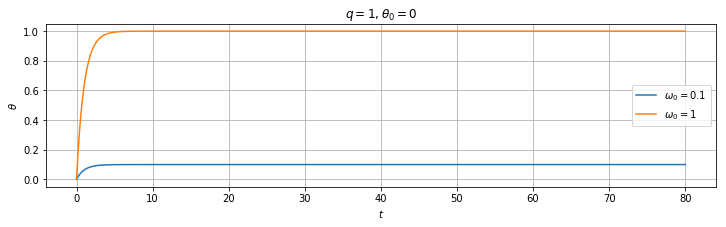

In [9]:
plt.figure(figsize=(12,3))

t,y = solve_ode(func,[0.,80.], 1600, [0.0,0.1], args=[0, 9.8, 1, 0, 0], method="RK4")
theta, omega = y.T
plt.plot(t,theta,label=r"$\omega_0 = 0.1$")

t,y = solve_ode(func,[0.,80.], 1600, [0.0,1], args=[0, 9.8, 1, 0, 0], method="RK4")
theta, omega = y.T
plt.plot(t,theta,label=r"$\omega_0 = 1$")

plt.title(r"$q = 1, \theta_0 = 0$")
plt.legend()
plt.grid()

plt.ylabel(r"$\theta$")
plt.xlabel(r"$t$")
plt.savefig("case_1_theta_vs_t_th0.png")

#### what's going on here? share your thoughts!

## Case 2: gravity only: $F_D=0, g/l=1, q = 0, \theta_0 < 0.1$ 

### Initial conditions: $\theta_0=\{0.05,0.1\}, \omega_0=0$

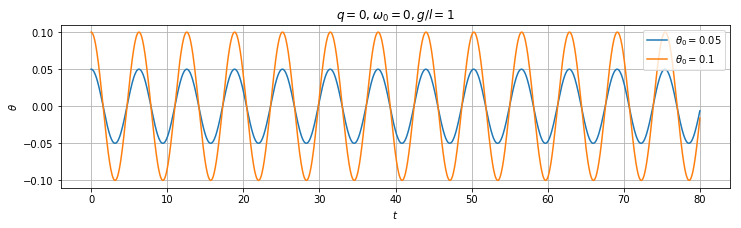

In [10]:
plt.figure(figsize=(12,3))

t,y = solve_ode(func,[0.,80.], 1600, [0.05,0], args=[9.8, 9.8, 0, 0, 0], method="RK4")
theta,omega = y.T
plt.plot(t,theta,label=r"$\theta_0 = 0.05$")

t,y = solve_ode(func,[0.,80.], 1600, [0.1,0], args=[9.8, 9.8, 0, 0, 0], method="RK4")
theta,omega = y.T
plt.plot(t,theta,label=r"$\theta_0 = 0.1$")

plt.title(r"$q = 0, \omega_0 = 0, g/l = 1$")
plt.legend()
plt.grid()

plt.ylabel(r"$\theta$")
plt.xlabel(r"$t$")
plt.savefig("case_2_theta_vs_t_om0.png")

#### what's going on here? share your thoughts!

### Initial conditions: $\theta_0=0, \omega_0=\{0.05,0.1\}$

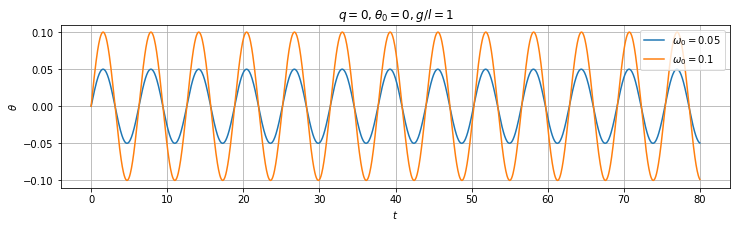

In [11]:
plt.figure(figsize=(12,3))

t,y = solve_ode(func,[0.,80.], 1600, [0,0.05], args=[9.8, 9.8, 0, 0, 0], method="RK4")
theta,omega = y.T
plt.plot(t,theta,label=r"$\omega_0 = 0.05$")

t,y = solve_ode(func,[0.,80.], 1600, [0,0.1], args=[9.8, 9.8, 0, 0, 0], method="RK4")
theta,omega = y.T
plt.plot(t,theta,label=r"$\omega_0 = 0.1$")

plt.title(r"$q = 0, \theta_0 = 0, g/l = 1$")
plt.legend()
plt.grid()

plt.ylabel(r"$\theta$")
plt.xlabel(r"$t$")
plt.savefig("case_2_theta_vs_t_th0.png")

#### what's going on here? share your thoughts!

## Take it from here!

### for every case, make plots, and explain what's going on

In [5]:
def angle_wrap(a): 
    b = a/(2.*np.pi)
    b -= np.floor(b)
    b -= (b>0.5)
    b *= 2.*np.pi
    return(b)

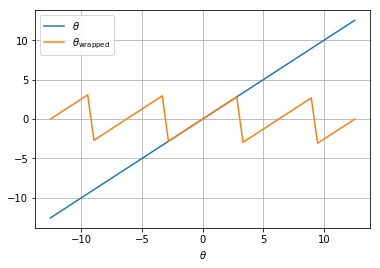

In [87]:
theta = np.linspace(-2,2)*2*np.pi
theta_wrapped = angle_wrap(theta)
plt.plot(theta,theta,label=r"$\theta$")
plt.plot(theta,theta_wrapped,label=r"$\theta_{\rm wrapped}$")
plt.xlabel(r"$\theta$")
plt.legend()
plt.grid()
plt.savefig("angle_wrapping.png")

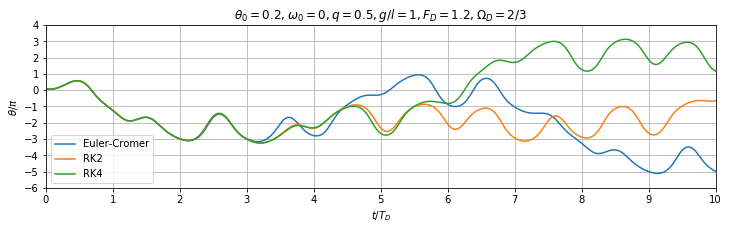

In [13]:
plt.figure(figsize=(12,3))

OmegaD = 2./3.
TD = 2*np.pi/OmegaD

t,y = solve_ode(func,[0.,100.], 2500, [0.2,0.], args=[9.8, 9.8, 0.5, 1.2, OmegaD], method="Euler-Cromer")
theta,omega = y.T
#theta = angle_wrap(theta)
plt.plot(t/TD,theta/np.pi,label=r"Euler-Cromer")

t,y = solve_ode(func,[0.,100.], 2500, [0.2,0.], args=[9.8, 9.8, 0.5, 1.2, OmegaD], method="RK2")
theta,omega = y.T
#theta = angle_wrap(theta)
plt.plot(t/TD,theta/np.pi,label=r"RK2")

t,y = solve_ode(func,[0.,100.], 2500, [0.2,0.], args=[9.8, 9.8, 0.5, 1.2, OmegaD], method="RK4")
theta,omega = y.T
#theta = angle_wrap(theta)
plt.plot(t/TD,theta/np.pi,label=r"RK4")

plt.title(r"$\theta_0 = 0.2, \omega_0 = 0, q = 0.5, g/l = 1, F_D = 1.2, \Omega_D = 2/3$")
plt.legend(loc="lower left")
plt.grid()

plt.ylabel(r"$\theta/\pi$")
plt.xlabel(r"$t/T_D$")

plt.xlim(0,10)
plt.ylim(-6,4)
plt.gca().set_xticks(np.arange(0,11))
plt.gca().set_yticks(np.arange(-6,5))
plt.savefig("Euler-Cromer-vs-RK4.png",bbox_inches='tight',pad_inches=0.02,dpi=300)

In [15]:
matrix = [[1,2,3],[4,5,6]]
row1,row2 = matrix
print(row1)
print(row2)

[1, 2, 3]
[4, 5, 6]


In [16]:
y = np.asarray([[1,2,3],[4,5,6]]).T
row1,row2=y.T
print(row1)
print(row2)

[1 2 3]
[4 5 6]


In [90]:
FD=1.2
OmegaD = 2./3.
TD = 2*np.pi/OmegaD
tmax=5*100.*TD
nsteps=200000
dt = tmax/nsteps
g = 9.8
l = 9.8
q = 0.3
dt = tmax/nsteps
t,y = solve_ode(func,[0.,tmax], nsteps, [0.2,0.], args=[g, l, q, FD, OmegaD], method="RK4")
theta,omega = y.T
theta = angle_wrap(theta)
dt = tmax/nsteps
print(dt)

0.0235619449019


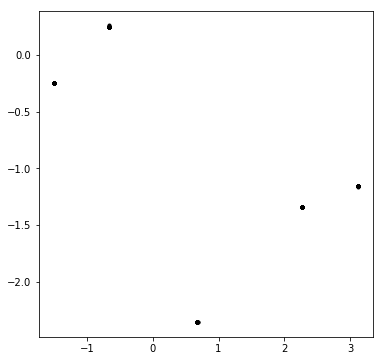

In [91]:
which = (np.abs(angle_wrap(OmegaD*t)/OmegaD)<0.5*dt)*(t>10*TD)
#which = np.ones_like(t)
plt.figure(figsize=(6,6))
plt.plot(theta[which],omega[which],"k.")
#plt.plot(theta,omega,"k.")

In [64]:
OmegaD = 2./3.
TD = 2*np.pi/OmegaD
tmax=1000.*TD
nsteps=200000
dt = tmax/nsteps

g = 9.8
l = 9.8
q = 0.5
i_array = []
t_array = []
th_array = []
om_array = []
FD_array = []
#FD_list = np.concatenate((np.linspace(1.4,1.475,6000,endpoint=0),np.linspace(1.474,1.5,6000)))
FD_list = np.concatenate((np.linspace(1.4,1.5,6000),np.linspace(1.4778,1.47785,4000)))
#FD_list = np.linspace(1.477,1.478,2000)
#FD_list = np.linspace(1.4,1.5,100)
for i,FD in enumerate(FD_list):
    t,y = solve_ode(func,[0.,tmax], nsteps, [0.2,0.], args=[g, l, q, FD, OmegaD], method="RK4")
    theta,omega = y.T
    theta = angle_wrap(theta)
    #keep only the values at the section in phase with the forcing
    which = (np.abs(angle_wrap(OmegaD*t)/OmegaD)<0.5*dt)*(t>20.*TD)
    t = t[which]
    theta = theta[which]
    omega = omega[which]
    #store these values
    i_array.append(i+0*t)
    t_array.append(t)
    th_array.append(theta)
    om_array.append(omega)
    FD_array.append(FD+0*t)
i_array_1d = np.asarray(i_array).flatten()
t_array_1d = np.asarray(t_array).flatten()
th_array_1d = np.asarray(th_array).flatten()
om_array_1d = np.asarray(om_array).flatten()
FD_array_1d = np.asarray(FD_array).flatten()
print("dt = %g" % dt)

dt = 0.0471239


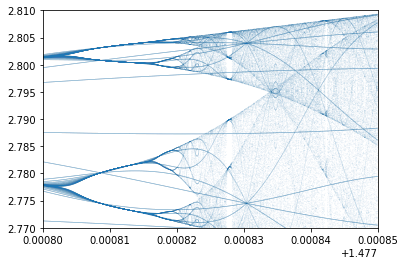

In [67]:
plt.figure(figsize=(6,4))
which = (np.abs(angle_wrap(OmegaD*t_array_1d)/OmegaD)<0.5*dt)*(t_array_1d>10*TD)
plt.scatter(FD_array_1d[which],th_array_1d[which],s=2,alpha=0.1,marker=".",edgecolors='none')
left =  1.4778
width = 0.00005
plt.xlim(left,left+width)
bottom = 2.77
height = 0.04
plt.ylim(bottom,bottom+height)
plt.savefig("bifurc_zoom.png",dpi=1200)


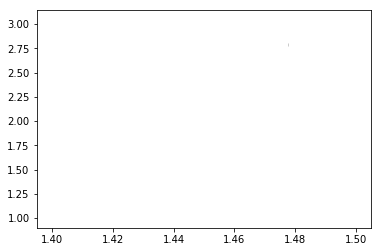

In [68]:
plt.figure(figsize=(6,4))
which = (np.abs(angle_wrap(OmegaD*t_array_1d)/OmegaD)<0.5*dt)*(t_array_1d>100)
plt.scatter(FD_array_1d[which],th_array_1d[which],s=0.05,alpha=0.1,marker=".",edgecolors='none')
#plt.plot([1.3,1.5],[0.9,np.pi])
#plt.xlim(1.3,1.5)
plt.ylim(0.9,np.pi)
###################################
# Build a rectangle in axes coords
###################################
ax = plt.gca()
p = plt.Rectangle((left, bottom), width, height, fill=False,alpha=0.2)
#p.set_transform(ax.transAxes)
#p.set_clip_on(False)
ax.add_patch(p)
###################################
plt.savefig("bifurc_full.png",dpi=2400,bbox_inches='tight',pad_inches=0.02)

In [44]:
which = (np.abs(angle_wrap(OmegaD*t_array_1d)/OmegaD)<0.5*dt)*(t_array_1d>100)
np.abs(angle_wrap(OmegaD*t_array_1d)/OmegaD)[which]

array([3.34835376e-14, 3.34835376e-14, 6.69670752e-14, ...,
       1.07147320e-12, 1.07147320e-12, 1.07147320e-12])

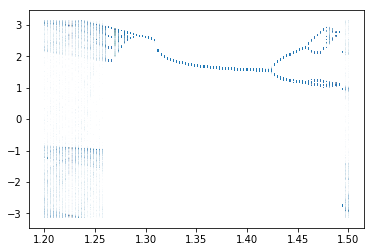

In [14]:
plt.figure(figsize=(6,4))
which = (np.abs(angle_wrap(OmegaD*t_array_1d)/OmegaD)<0.5*dt)*(t_array_1d>100)
plt.scatter(FD_array_1d[which],th_array_1d[which],s=0.1,alpha=1,marker=".",edgecolors='none')
#plt.xlim(1.050,1.100)
#plt.ylim(-3,-2.75)
plt.savefig("bifurc_th_full.png")

In [ ]:
OmegaD = 2./3.
TD = 2*np.pi/OmegaD
tmax=1000.*TD
nsteps=200000
dt = tmax/nsteps

FD = 1.2
g = 9.8
l = 9.8
q = 0.5
i_array = []
t_array = []
th_array = []
om_array = []
FD_array = []
q_array = []
q_list = np.linspace(0.1,1,100)
for i,q in enumerate(q_list):
    t,y = solve_ode(func,[0.,tmax], nsteps, [0.2,0.], args=[g, l, q, FD, OmegaD], method="RK4")
    theta,omega = y.T
    theta = angle_wrap(theta)
    #keep only the values at the section in phase with the forcing
    which = (np.abs(angle_wrap(OmegaD*t)/OmegaD)<0.5*dt)*(t>20.*TD)
    t = t[which]
    theta = theta[which]
    omega = omega[which]
    #store these values
    i_array.append(i+0*t)
    t_array.append(t)
    th_array.append(theta)
    om_array.append(omega)
    FD_array.append(FD+0*t)
i_array_1d = np.asarray(i_array).flatten()
t_array_1d = np.asarray(t_array).flatten()
th_array_1d = np.asarray(th_array).flatten()
om_array_1d = np.asarray(om_array).flatten()
FD_array_1d = np.asarray(FD_array).flatten()
print("dt = %g" % dt)

In [ ]:
x = np.linspace(-1000,1000,1000)
y = np.linspace(-1000,1000,1000)
x2d = x[:,None]+0*y[None,:]
y2d = 0*x[:,None]+y[None,:]
B = 1
nu = 1
area = np.pi*x2d**2
theta = np.arctan2(x2d,y2d)
r = (x2d**2+y2d**2)**0.5
aphi = r**nu*(1-np.abs(np.cos(theta)))
#plt.contour(x2d,y2d,np.abs(aphi)**0.5*np.sign(aphi),10)
plt.contour(x2d,y2d,np.abs(aphi),100)

In [ ]:
plt.plot(x2d[:,500],aphi[:,500])
plt.plot(x2d[:,999],aphi[:,999])

In [ ]:
plt.plot(x2d[:,500],aphi[:,500]**0.5)
plt.plot(x2d[:,999],aphi[:,999]**0.5)